# **Import all the Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# **Set all the Constants**

In [ ]:
BATCH_SIZE =5
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# **Import data into tensorflow dataset object**

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/ds_frutas_am/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 90 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
class_names

['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(5, 256, 256, 3)
[4 1 2 1 4]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

# **Visualize some of the images from our dataset**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


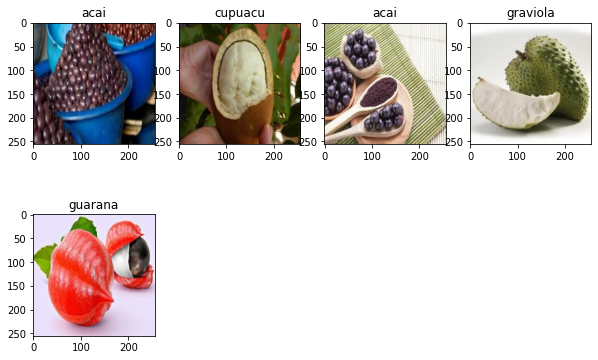

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset:
  for i in range(5):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])

# **Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:

1) Training: Dataset to be used while training

2)Validation: Dataset to be tested against while training

3)Test: Dataset to be tested against after we trained a model

In [ ]:
def get_data_partition(ds,training_size=0.7,test_size=0.15,val_size=0.15):
  # taking length of dataset
  len_ds=len(ds)

  # taking length of partition
  training=int(len_ds*training_size)
  val=int(len_ds*val_size)
   ## Taking values of partition
  train_ds=ds.take(training)
  val_ds=ds.skip(training).take(val)
  test_ds=ds.skip(training).skip(val)

  return train_ds, val_ds, test_ds




In [ ]:
train_ds, val_ds, test_ds = get_data_partition(dataset)

# **Cache, Shuffle, and Prefetch the Dataset**

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Building the Model**

# **Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# **Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [ ]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (5, 256, 256, 3)          0         
                                                                 
 sequential_1 (Sequential)   (5, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (5, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (5, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (5, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (5, 62, 62, 64)          0         
 2D)                                                  

# **Compiling the Model**

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=10,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
14/14 [==============================] - 10s 593ms/step - loss: 1.8058 - accuracy: 0.1429 - val_loss: 1.7601 - val_accuracy: 0.6000
Epoch 2/50
14/14 [==============================] - 8s 546ms/step - loss: 1.7883 - accuracy: 0.2000 - val_loss: 1.7738 - val_accuracy: 0.0000e+00
Epoch 3/50
14/14 [==============================] - 8s 568ms/step - loss: 1.6764 - accuracy: 0.2429 - val_loss: 1.9252 - val_accuracy: 0.0000e+00
Epoch 4/50
14/14 [==============================] - 8s 566ms/step - loss: 1.6029 - accuracy: 0.2714 - val_loss: 1.4985 - val_accuracy: 0.2000
Epoch 5/50
14/14 [==============================] - 8s 549ms/step - loss: 1.5234 - accuracy: 0.3571 - val_loss: 1.6969 - val_accuracy: 0.4000
Epoch 6/50
14/14 [==============================] - 8s 551ms/step - loss: 1.5089 - accuracy: 0.3143 - val_loss: 1.9752 - val_accuracy: 0.2000
Epoch 7/50
14/14 [==============================] - 8s 549ms/step - loss: 1.3237 - accuracy: 0.3286 - val_loss: 1.4183 - val_accuracy: 0.20

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

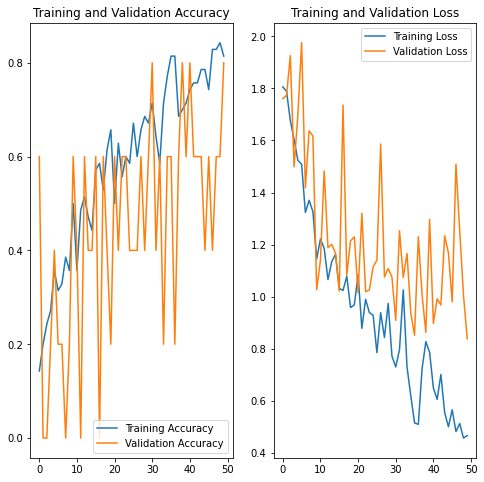

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Run prediction on a sample image**

first image to predict
actual label: graviola
predicted label: graviola


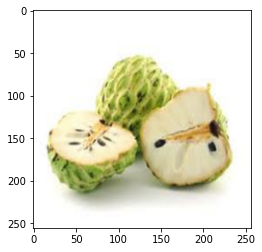

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# **Write a function for inference**

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# **Now run inference on few sample images**

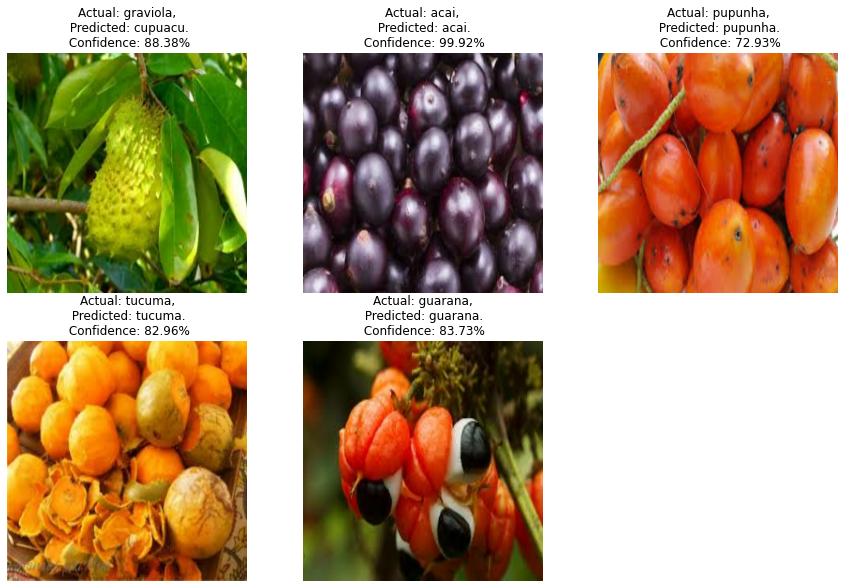

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# **Saving the Model**

We append the model to the list of models as a new version

In [ ]:
import os
model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


In [ ]:
model.save("fruit_classification.h5")